# Iris classification with FermionicPQCKernel


<table class="nt-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://MatchCake.github.io/MatchCake/"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/logo_32px.png?raw=true" width=32px height=32px  />Documentation</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/colab_logo_32px.png?raw=true" width=32px height=32px  />Run in Google Colab</a>
</td>
  <td>
    <a target="_blank" href="https://github.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width=32px height=32px />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/download_logo_32px.png?raw=true" width=32px height=32px />Download notebook</a>
  </td>
</table>

In this example, you will see how to do data classification with the `FermionicPQCKernel` from the MatchCake package. The `FermionicPQCKernel` is a kernel that encode the data into fermionic rotations gates before using fSWAP gate to entangle the nearest neighbours qubits together.

# Setup

You can now install the dependencies by running the following commands:

In [1]:
#@title Install dependencies {display-mode: "form"}

RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    !pip install matchcake

# Imports

First, we need to import the necessary packages. We will use the `datasets` module from `sklearn` to load the Iris dataset, the `train_test_split` function to split the dataset into training and testing sets, and the `MinMaxScaler` to scale the data and others.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from matchcake.ml.kernels import FermionicPQCKernel
from matchcake.ml.visualisation import ClassificationVisualizer
from matchcake.ml.kernels.linear_nif_kernel import LinearNIFKernel

# Parameters

We will define our hyperparameters here. We will use 4 qubits to encode the data.

In [3]:
n_qubits = 4

# Load the data

We will load the Iris dataset.

In [4]:
dataset = datasets.load_iris(as_frame=True)
X, y = dataset.data, dataset.target

# Split the data

We will split the data into training and testing sets.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the SKlearn Pipeline

We will build the model using the `FermionicPQCKernel`.

In [6]:
pipline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('kernel', FermionicPQCKernel(n_qubits=n_qubits, rotations="X,Z").freeze()),
    ('classifier', SVC(kernel='precomputed')),
])

As for comparison, we can compare the `FermionicPQCKernel` with the `LinearNIFKernel` which use a linear layer to generate fermionic parameters.

In [7]:
linear_pipline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('kernel', LinearNIFKernel(n_qubits=n_qubits)),
    ('classifier', SVC(kernel='precomputed')),
])

# Train the model

We will train the model using the training data.

In [8]:
pipline.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kernel',
                 FermionicPQCKernel(depth=1, n_qubits=4, rotations='X,Z')),
                ('classifier', SVC(kernel='precomputed'))])

In [9]:
linear_pipline.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kernel', LinearNIFKernel(n_qubits=4)),
                ('classifier', SVC(kernel='precomputed'))])

# Evaluate the Pipeline

We will evaluate the pipeline using the testing data.

In [10]:
pipline["kernel"].freeze()
test_accuracy = pipline.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 93.33%


In [11]:
linear_pipline["kernel"].freeze()
test_accuracy = linear_pipline.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 90.00%


# Visualize the results

We can visualize the decision boundaries of the model.

/home/local/USHERBROOKE/ginj2102/github/MatchCake/.venv/lib/python3.12/site-packages/sklearn/utils/estimator_checks.py:872: SkipTestWarning: Skipping check check_array_api_input for PCA because it raised SkipTest: array_api_compat is not installed: not checking array_api input
  warnings.warn(
/home/local/USHERBROOKE/ginj2102/github/MatchCake/.venv/lib/python3.12/site-packages/sklearn/utils/estimator_checks.py:872: SkipTestWarning: Skipping check check_array_api_input for PCA because it raised SkipTest: array_api_strict is not installed: not checking array_api input
  warnings.warn(
/home/local/USHERBROOKE/ginj2102/github/MatchCake/.venv/lib/python3.12/site-packages/sklearn/utils/estimator_checks.py:872: SkipTestWarning: Skipping check check_array_api_input for PCA because it raised SkipTest: cupy is not installed: not checking array_api input
  warnings.warn(
/home/local/USHERBROOKE/ginj2102/github/MatchCake/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarn

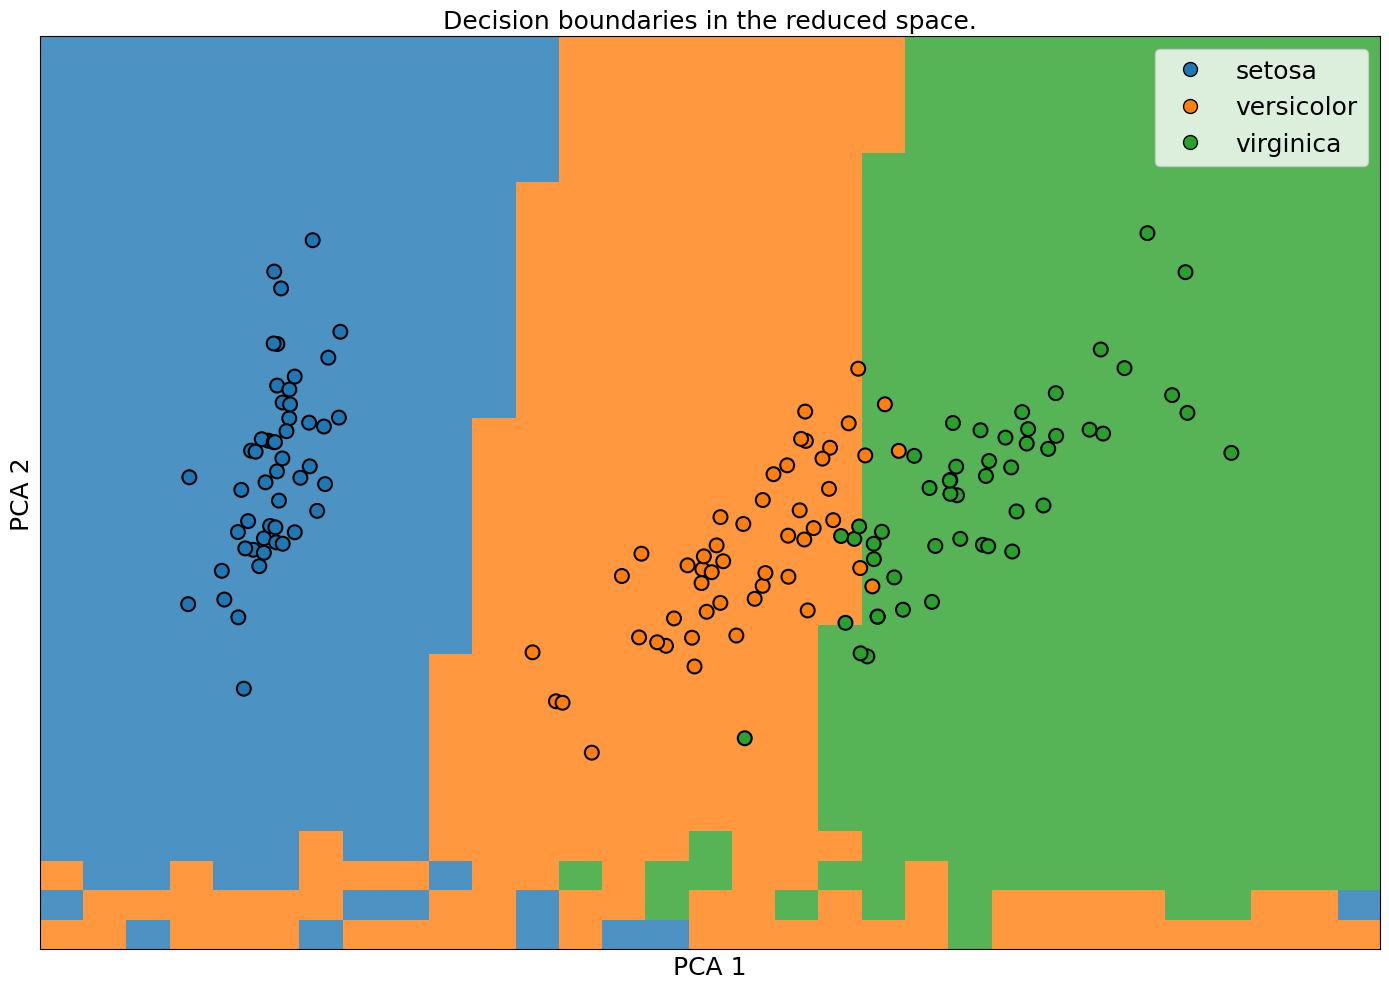

In [12]:
viz = ClassificationVisualizer(x=X, n_pts=1_000)
fig, ax, y_pred = viz.plot_2d_decision_boundaries(
    model=pipline, y=y, legend_labels=getattr(dataset, "target_names", None), show=True
)

/home/local/USHERBROOKE/ginj2102/github/MatchCake/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


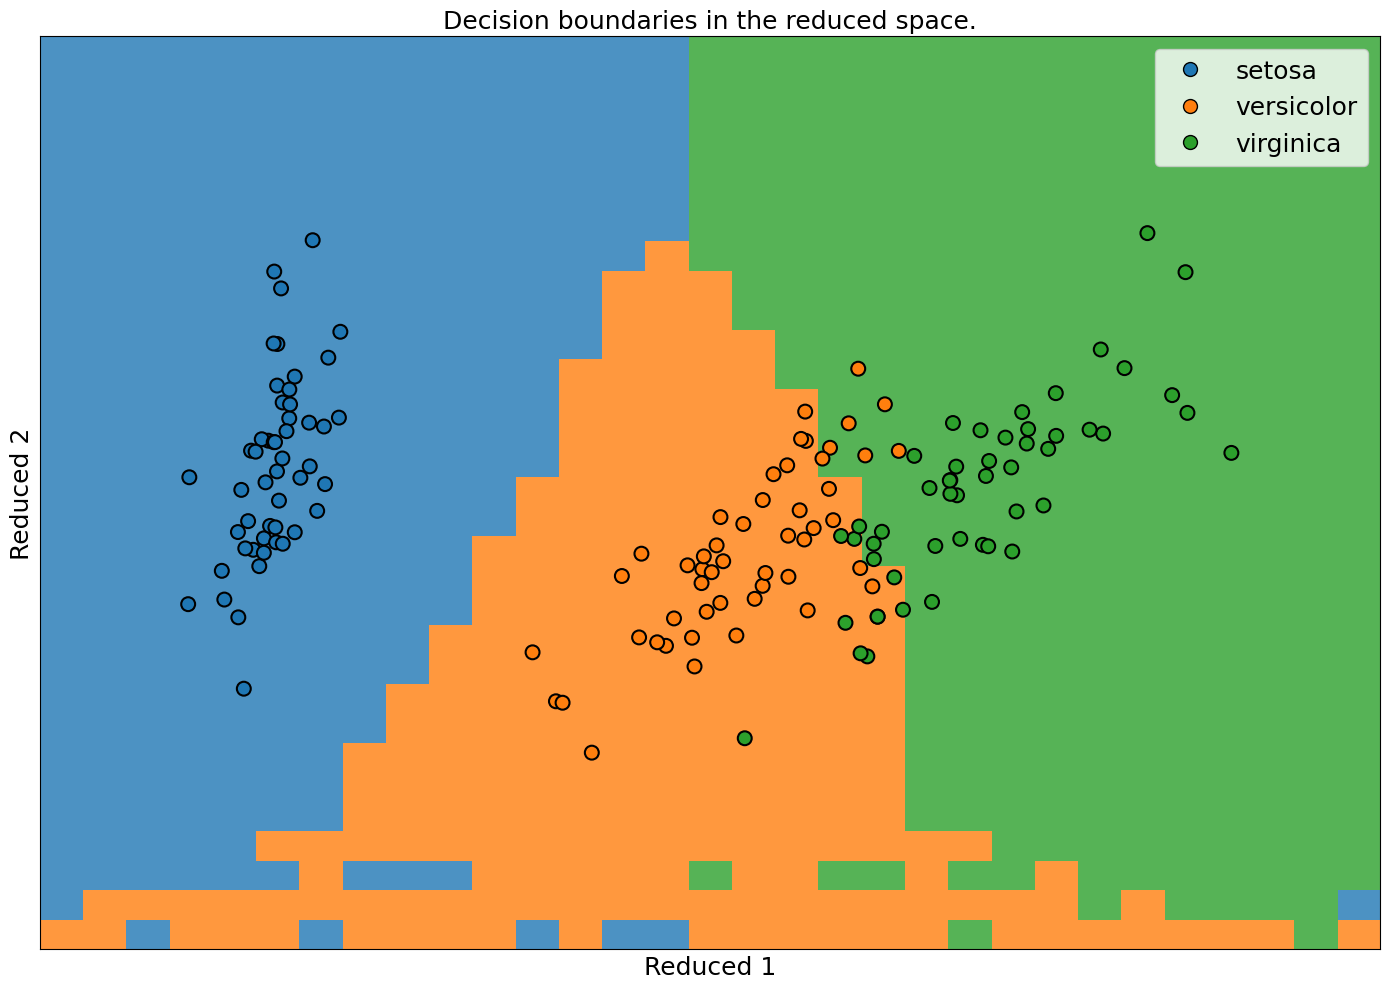

In [13]:
fig, ax, y_pred = viz.plot_2d_decision_boundaries(
    model=linear_pipline, y=y, legend_labels=getattr(dataset, "target_names", None), show=True
)

----------